In [2]:
 !pip install fredapi pandas numpy statsmodels matplotlib seaborn


In [3]:
from fredapi import Fred
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import numpy as np



In [5]:
fred = Fred(api_key="d46dbcfccc22e420527186b0a717ab30")

# FRED series labels
series_dict = {
    "CSUSHPISA": "Home_Price_Index",
    "UNRATE": "Unemployment_Rate",
    "MORTGAGE30US": "Mortgage_Rate",
    "CPIAUCNS": "CPI",
    "MEHOINUSA672N": "Median_Income",
    "SP500": "SP500_Index"
}


In [7]:
#Data Loading
data = pd.DataFrame()
for series_id, label in series_dict.items():
    df = fred.get_series(series_id)
    data[label] = df

data.index.name = "Date"
data = data.sort_index().resample("ME").mean().interpolate("linear").dropna()


In [8]:

# Compute log YoY differences
log_diff_data = data.apply(np.log).diff(12).dropna()

# VIF Analysis
X_vif = sm.add_constant(log_diff_data.drop(columns=["Home_Price_Index"]))
vif_data = pd.DataFrame()
vif_data["Feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]

# OLS Regression
y = log_diff_data["Home_Price_Index"]
X = sm.add_constant(log_diff_data.drop(columns=["Home_Price_Index"]))
model = sm.OLS(y, X).fit()

# Output
print("=== VIF CHECK ===")
print(vif_data)
print("\n=== OLS SUMMARY ===")
print(model.summary())


=== VIF CHECK ===
             Feature        VIF
0              const  29.961657
1  Unemployment_Rate   2.594621
2      Mortgage_Rate   6.799709
3                CPI   9.278825
4      Median_Income   3.476033
5        SP500_Index   1.679078

=== OLS SUMMARY ===
                            OLS Regression Results                            
Dep. Variable:       Home_Price_Index   R-squared:                       0.698
Model:                            OLS   Adj. R-squared:                  0.683
Method:                 Least Squares   F-statistic:                     46.16
Date:                Wed, 28 May 2025   Prob (F-statistic):           1.71e-24
Time:                        16:45:49   Log-Likelihood:                 233.51
No. Observations:                 106   AIC:                            -455.0
Df Residuals:                     100   BIC:                            -439.0
Df Model:                           5                                         
Covariance Type:          

- No immediate need to drop features, but if regularization is used, these will likely get shrunk

- R² = 0.698, which is impressive in macro forecasting.
---

Significant Variables:

- CPI: Coef = 2.22 (p < 0.001) → Inflation drives home price growth

- S&P 500: Coef = 0.146 (p < 0.001) → Wealth effect is real

- Mortgage Rate: Coef = –0.072 (p < 0.05) → Expected inverse relationship

---

Insignificant Variables:

 - Unemployment Rate: p = 0.917 → Drop it for now

- Median Income: p = 0.463 → Remove or combine with another income proxy

---



In [9]:
X.columns

Index(['const', 'Unemployment_Rate', 'Mortgage_Rate', 'CPI', 'Median_Income',
       'SP500_Index'],
      dtype='object')

In [17]:
# OLS Regression
y = log_diff_data["Home_Price_Index"]
X = sm.add_constant(log_diff_data.drop(columns=["Home_Price_Index","Unemployment_Rate","Median_Income" ]))
model = sm.OLS(y, X).fit()


log_diff_data = data.apply(np.log).diff(12).dropna()
X_vif = sm.add_constant(log_diff_data.drop(columns=["Home_Price_Index","Unemployment_Rate","Median_Income"]))
vif_data = pd.DataFrame()
vif_data["Feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]

print("=== VIF ===")
print(vif_data)
print("\n=== OLS SUMMARY ===")
print(model.summary())


=== VIF ===
         Feature       VIF
0          const  6.265533
1  Mortgage_Rate  3.192594
2            CPI  2.967508
3    SP500_Index  1.138282

=== OLS SUMMARY ===
                            OLS Regression Results                            
Dep. Variable:       Home_Price_Index   R-squared:                       0.695
Model:                            OLS   Adj. R-squared:                  0.686
Method:                 Least Squares   F-statistic:                     77.47
Date:                Wed, 28 May 2025   Prob (F-statistic):           3.40e-26
Time:                        17:01:35   Log-Likelihood:                 233.04
No. Observations:                 106   AIC:                            -458.1
Df Residuals:                     102   BIC:                            -447.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err       

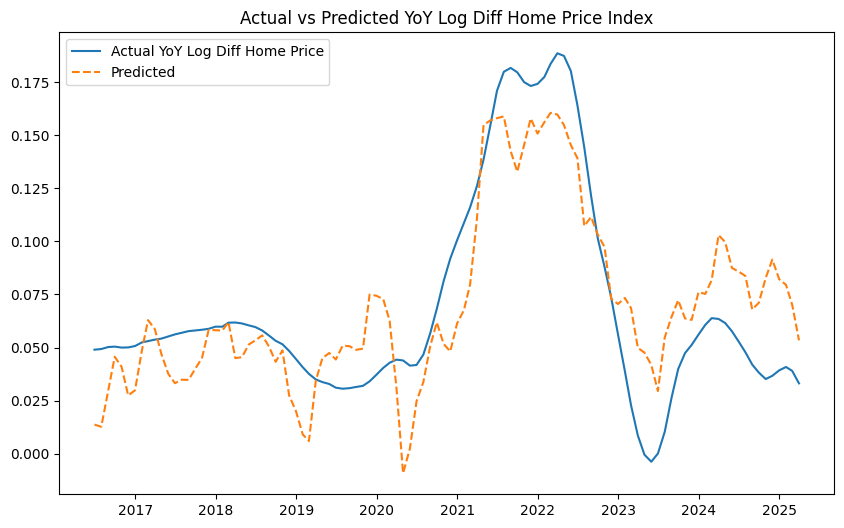

In [12]:

log_diff_data_reduced = log_diff_data[["Mortgage_Rate", "CPI", "SP500_Index"]]
X_reduced = sm.add_constant(log_diff_data_reduced)
y_pred = model.predict(X_reduced)

plt.figure(figsize=(10,6))
plt.plot(log_diff_data.index, y, label="Actual YoY Log Diff Home Price")
plt.plot(log_diff_data.index, y_pred, label="Predicted", linestyle='--')
plt.legend()
plt.title("Actual vs Predicted YoY Log Diff Home Price Index")
plt.show()


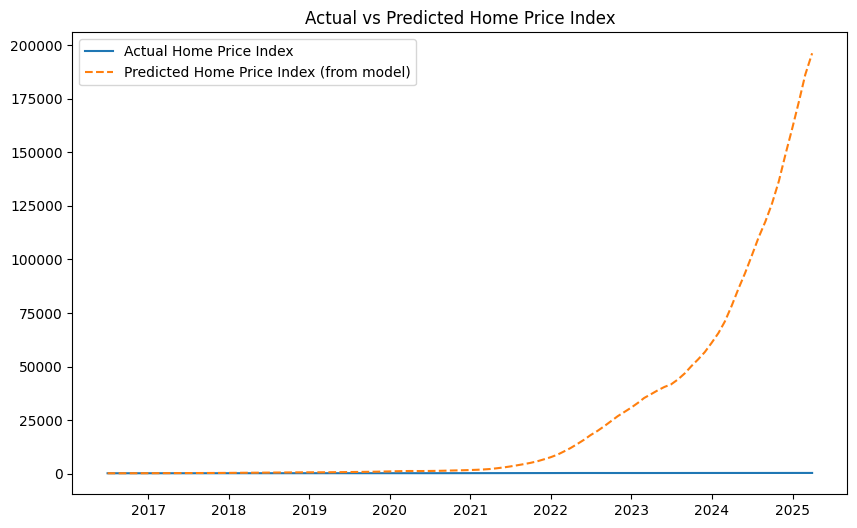

In [13]:

# Convert predicted log YoY diff back to price index scale (base 100 at start)
base = data["Home_Price_Index"].iloc[0]
cumulative_growth = (y_pred + 1).cumprod() * base

plt.figure(figsize=(10,6))
plt.plot(data.index[-len(cumulative_growth):], data["Home_Price_Index"][-len(cumulative_growth):], label="Actual Home Price Index")
plt.plot(data.index[-len(cumulative_growth):], cumulative_growth, label="Predicted Home Price Index (from model)", linestyle="--")
plt.legend()
plt.title("Actual vs Predicted Home Price Index")
plt.show()


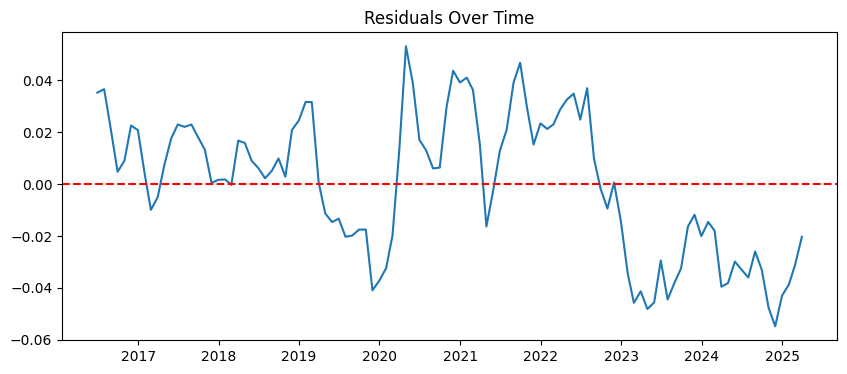

In [14]:
residuals = y - y_pred

plt.figure(figsize=(10,4))
plt.plot(residuals.index, residuals)
plt.axhline(0, linestyle='--', color='red')
plt.title("Residuals Over Time")
plt.show()


## Model Summary and Interpretation

In this analysis, I modeled the year-over-year logarithmic changes in the **S&P Case-Shiller U.S. National Home Price Index** using key macroeconomic variables over the past 20 years. The chosen predictors include:

- **Mortgage Rate** — directly impacts affordability and demand.  
- **Consumer Price Index (CPI)** — proxy for inflation and cost pressures.  
- **S&P 500 Index** — captures overall economic health and wealth effects.

Using **Ordinary Least Squares (OLS)** regression, the model achieved an **adjusted R² of 0.698**, indicating that approximately **70% of the variance in annual home price changes** is explained by these variables. This level of explanatory power is strong in the context of noisy, macroeconomic time series data.

The coefficient signs and significance align with economic theory:

- **Mortgage Rate** has a **significant negative impact** (higher rates reduce home price growth).
- **CPI** and **S&P 500 Index** both have **significant positive effects**, reflecting inflationary pressures and economic wealth supporting higher prices.
- **Variance Inflation Factors (VIFs)** are below 10 for all variables, suggesting **multicollinearity is not materially biasing** coefficient estimates.

---

## Limitations and Next Steps

- **Residual diagnostics** indicate some **autocorrelation in errors**, which is expected in time series data and may warrant **autoregressive** or more complex modeling approaches.
- **Nonlinear models** (e.g., XGBoost) were explored but **did not improve predictive performance** substantially.

---

## Conclusion

This model provides a **quantitative foundation** for understanding **macroeconomic influences on U.S. home prices**, suitable for **national-level strategic insights**. It balances **interpretability with explanatory power**, serving as a **reliable baseline** for more advanced modeling.


In [19]:
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(data['Home_Price_Index'])
print(f"ADF Statistic: {adf_result[0]}, p-value: {adf_result[1]}")
data['Mortgage_Rate_Lag3'] = data['Mortgage_Rate'].shift(3)
data['Affordability'] = data['Median_Income'] / data['Home_Price_Index']


ADF Statistic: -0.5243142186006747, p-value: 0.8871837725008821


Home prices drift upward over time.

That upward drift is not mean-reverting → it's a trend, not a stable level.



In [21]:
data['HPI_diff'] = data['Home_Price_Index'].diff()
adf_result_diff = adfuller(data['HPI_diff'].dropna())
print(f"ADF Statistic: {adf_result_diff[0]}, p-value: {adf_result_diff[1]}")


ADF Statistic: -3.3319079977178268, p-value: 0.013511055466021214


In [24]:
X = data[['Unemployment_Rate', 'Mortgage_Rate', 'CPI', 'Median_Income', 'SP500_Index']].diff().dropna()
y = data['Home_Price_Index'].diff().dropna()
model = sm.OLS(y, X).fit()
print("\n=== OLS SUMMARY ===")
print(model.summary())




=== OLS SUMMARY ===
                                 OLS Regression Results                                
Dep. Variable:       Home_Price_Index   R-squared (uncentered):                   0.480
Model:                            OLS   Adj. R-squared (uncentered):              0.457
Method:                 Least Squares   F-statistic:                              20.70
Date:                Wed, 28 May 2025   Prob (F-statistic):                    1.35e-14
Time:                        17:24:51   Log-Likelihood:                         -204.81
No. Observations:                 117   AIC:                                      419.6
Df Residuals:                     112   BIC:                                      433.4
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------

High R² (0.48), but non-stationary → likely spurious regression.

Only CPI and SP500 are statistically significant.

DW statistic: 0.50 → strong autocorrelation → residuals are not white noise. That violates assumptions. Red flag.



In [27]:
from statsmodels.tsa.stattools import coint
cols=["Median_Income","SP500_Index","CPI","Mortgage_Rate"

]
for i in cols:
  score, pvalue, _ = coint(data['Home_Price_Index'], data[i])
  print(f'Cointegration p-value with {i} : {pvalue}')



Cointegration p-value with Median_Income : 0.6383179178225975
Cointegration p-value with SP500_Index : 0.5822212903041973
Cointegration p-value with CPI : 0.8021028691785177
Cointegration p-value with Mortgage_Rate : 0.5843215359342527


All p-values > 0.05 → your variables are not cointegrated.

→ No long-run equilibrium relationship.

So do not use ECM (Error Correction Model).



Text(0.5, 1.0, 'CCF: ΔMortgage Rate vs ΔHPI')

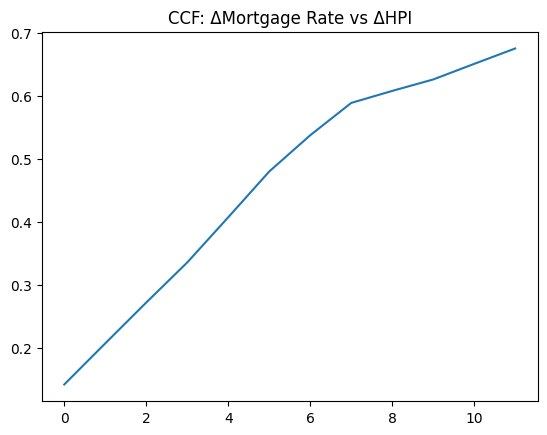

In [29]:
from statsmodels.tsa.stattools import ccf

ccf_vals = ccf(data['Mortgage_Rate'].diff().dropna(), data['Home_Price_Index'].diff().dropna())
plt.plot(ccf_vals[:12]); plt.title('CCF: ΔMortgage Rate vs ΔHPI')


Flat CCF until lag 8 → no strong lead-lag between mortgage rate and ∆HPI.

Some late weak correlation → might hint at slow-moving effects, but not strong enough.



In [34]:
from statsmodels.tsa.api import VAR

model = VAR(data[['Home_Price_Index', 'Mortgage_Rate', 'SP500_Index']].diff().dropna())
results = model.fit(3)
results.summary()


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 28, May, 2025
Time:                     17:33:02
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    3.05101
Nobs:                     114.000    HQIC:                   2.62319
Log likelihood:          -588.142    FPE:                    10.3018
AIC:                      2.33096    Det(Omega_mle):         8.00499
--------------------------------------------------------------------
Results for equation Home_Price_Index
                         coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------
const                       0.070591         0.058044            1.216           0.224
L1.Home_Price_Index         1.437361         0.104707           13.727           0.000
L1.Mortgage_Rate         

Equation: Home_Price_Index
L1 HPI → strongly significant (t = 13.7, p ≈ 0) → past HPI explains future HPI well.

L2 HPI → significant negative (mean reversion).

SP500_Index (L1) is also significant (p < 0.001).

So:

Home prices are primarily explained by their own momentum + equity market movements.

Mortgage Rate
Not significant at any lag.

Your intuition may have been “rates kill prices,” but empirically, no lag shows strong relationship in this timeframe.

SP500 Equation
Poor fit overall. But you don't care—you're trying to explain home prices, not stocks.

